In [147]:
import nest_asyncio
import numpy as np
import pandas as pd
import pyshark
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sns.set_style("whitegrid")
nest_asyncio.apply()

In [148]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

In [149]:
numPcaps = 63
fileName = "pcap-run-1.pcap"

pcapsFolder = Path("powerowl_example_results/pcaps")

sourceIP = "172.16.0.2" # MTU IP

REMOVE_S_PACKETS = False
apduTypeMap = {
    '0x00000000':"I",
    '0x00000001':"S",
    '0x00000003':"U"
}
filePaths = [pcapsFolder.joinpath(f"pcap-run-{i}.pcap") for i in range(numPcaps)]
# Filter all packets that have an APCI and (if present) and ASDU 
caps = [pyshark.FileCapture(filePath, display_filter="iec60870_104", use_json=True) for filePath in filePaths]

In [150]:
def computeTopologicalMetrics(df: pd.DataFrame):
    G = nx.Graph()
    nodesArr = df["dest"].unique()    
    G.add_nodes_from(nodesArr)
    color_map = ['red' if node == sourceIP else 'blue' for node in G]
    print(len(G.nodes))
    for index, pckt in df.iterrows():
        G.add_edge(pckt["src"], pckt["dest"])

    avgDegree = np.mean([d[1] for d in list(G.degree())])
    L = nx.normalized_laplacian_matrix(G)
    e = np.linalg.eigvals(L.toarray())

    print(f"Average degree: {avgDegree:.3f}")
    print("Largest eigenvalue:", max(e))

    return avgDegree, max(e)

def computeThrPcktHour(df: pd.DataFrame):
    totSize = sum(df["length"])
    capDuration = (df.loc[len(df)-1]["timestamp"] - df.loc[0]["timestamp"])
    throughput = totSize / capDuration

    packtPerHour = (len(df)*3600) / capDuration
    print(f"Throughput: {throughput:.3f} bytes / second")
    print(f"Packet / hour: {(packtPerHour):.3f}")

    return throughput, packtPerHour

def computeIATDist(df: pd.DataFrame):
    #dfC = df[df["dest"] == sourceIP].reset_index(drop=True)

    iats = []
    for i in range(1, len(df)):
        iat = df.loc[i]["timestamp"] - df.loc[i-1]["timestamp"]
        iats.append(iat)

    return np.mean(iats), np.median(iats), np.min(iats), np.max(iats), np.percentile(iats, 25), np.percentile(iats, 75)

def computeCommandsIATDist(df: pd.DataFrame):
    hosts = df["dest"].unique()
    actuators = np.delete(hosts, np.where(hosts == sourceIP))

    iats = []
    # For each actuator, compute the IAT of commands sent to it
    # Commands are ASDU type 45
    for actuator in actuators:
        dfC = df[(df["dest"] == actuator) & (df["iec104_asdu_typeid"] == "45")]
        dfC.reset_index(drop=True, inplace=True)
        for i in range(1, len(dfC)):
            iat = dfC.loc[i]["timestamp"] - dfC.loc[i-1]["timestamp"]
            iats.append(iat)
    if len(iats) == 0:
        totSec = (df.loc[len(df)-1]["timestamp"] - df.loc[0]["timestamp"])
        iats = [totSec]
    return np.mean(iats), np.median(iats), np.min(iats), np.max(iats), np.percentile(iats, 25), np.percentile(iats, 75)

def computePacketDirection(df: pd.DataFrame):
    sns.set_theme(style="whitegrid",font_scale=1.3)
    numC2A = len(df[df["src"] == sourceIP])
    numA2C = len(df) - numC2A
    uniqueHosts = len(df["src"].unique())

    percA2C = (numA2C / (numC2A + numA2C)) * 100
    percC2A = (numC2A / (numC2A + numA2C)) * 100
    print(f"Num of unique hosts: {uniqueHosts}")
    print(f"Num a2C: {numA2C} ({percA2C:.2f}%)")
    print(f"Num C2a: {numC2A} ({percC2A:.2f}%)")

    return percA2C, percC2A

def computeBytesPerPcktDist(df: pd.DataFrame):
    return np.mean(df["length"]), np.median(df["length"]), np.min(df["length"]), np.max(df["length"]), np.percentile(df["length"], 25), np.percentile(df["length"], 75)

def computeASDUTypePerc(df: pd.DataFrame):
    counts = df["iec104_asdu_typeid"].value_counts(normalize=True)
    # Return a disctionary ASDUType: percentage
    percents = {k: v for k, v in counts.items()}
    return percents

def computeAPDUTypePerc(df: pd.DataFrame):
    iec104_type_freq = df["iec104_type"].value_counts(normalize=True)
    percents = {k: v for k, v in iec104_type_freq.items()}
    return percents

def computeSRateDist(df: pd.DataFrame):
    # S-Rate calculation
    hosts = df["dest"].unique()
    actuators = np.delete(hosts, np.where(hosts == sourceIP))

    sRates = {}
    for actuator in actuators:
        dfI = df[(df["src"] == actuator) & (df["iec104_asdu_typeid"] == "13")].reset_index(drop=True)
        dfS = df[(df["dest"] == actuator)].reset_index(drop=True)
        countI = dfI["iec104_type"].value_counts()
        countS = dfS["iec104_type"].value_counts()
        try:
            sRate = int(countI.I / countS.S)
        except AttributeError as e:
            sRate = float("NaN")

        sRates[actuator] = sRate
    sRatesVals = list(sRates.values())
    return np.nanmean(sRatesVals), np.nanmedian(sRatesVals), np.nanmin(sRatesVals), np.nanmax(sRatesVals), np.nanpercentile(sRatesVals, 25), np.nanpercentile(sRatesVals, 75)

In [151]:
from datetime import datetime
pcapFeatures = pd.DataFrame(columns=["avgDegree", "maxEigVal", "throughput", "packetsPerHour", "meanIAT", "medianIAT", "minIAT", "maxIAT", "perc25IAT", "perc75IAT",
                                     "meanCmdIAT", "medianCmdIAT", "minCmdIAT", "maxCmdIAT", "perc25CmdIAT", "perc75CmdIAT",
                                     "percA2C", "percC2A", "meanBytesPerPckt", "medianBytesPerPckt", "minBytesPerPckt", "maxBytesPerPckt", "perc25BytesPerPckt", "perc75BytesPerPckt"])
capNum = 0
for cap in caps:
    num = 0
    totSize = 0
    df = pd.DataFrame(columns=["timestamp", "length", "src", "dest", "iec104_type", "iec104_asdu_typeid"])
    pcktNum = 0
    for packet in cap:
        try:
            df.loc[num] = [datetime.timestamp(packet.sniff_time), packet.length, packet.ip.src, packet.ip.dst, apduTypeMap[packet.iec60870_104.type], str(packet.iec60870_asdu.typeid)]
        except AttributeError:
            df.loc[num] = [datetime.timestamp(packet.sniff_time), packet.length, packet.ip.src, packet.ip.dst, apduTypeMap[packet.iec60870_104.type], None]
        totSize += packet.length
        num+=1
    totSec = (df.loc[len(df)-1]["timestamp"] - df.loc[0]["timestamp"])
    print("Total seconds:", totSec)
    pcapFeaturesDict = {}
    if len(df) > 0:
        pcapFeaturesDict["avgDegree"], pcapFeaturesDict["maxEigVal"] = computeTopologicalMetrics(df)
        pcapFeaturesDict["throughput"], pcapFeaturesDict["packetsPerHour"] = computeThrPcktHour(df)
        pcapFeaturesDict["meanIAT"], pcapFeaturesDict["medianIAT"], pcapFeaturesDict["minIAT"], pcapFeaturesDict["maxIAT"], pcapFeaturesDict["perc25IAT"], pcapFeaturesDict["perc75IAT"] = computeIATDist(df)
        pcapFeaturesDict["meanCmdIAT"], pcapFeaturesDict["medianCmdIAT"], pcapFeaturesDict["minCmdIAT"], pcapFeaturesDict["maxCmdIAT"], pcapFeaturesDict["perc25CmdIAT"], pcapFeaturesDict["perc75CmdIAT"] = computeCommandsIATDist(df)
        pcapFeaturesDict["percA2C"], pcapFeaturesDict["percC2A"] = computePacketDirection(df)
        pcapFeaturesDict["meanBytesPerPckt"], pcapFeaturesDict["medianBytesPerPckt"], pcapFeaturesDict["minBytesPerPckt"], pcapFeaturesDict["maxBytesPerPckt"], pcapFeaturesDict["perc25BytesPerPckt"], pcapFeaturesDict["perc75BytesPerPckt"] = computeBytesPerPcktDist(df)
        asduTypePerc = computeASDUTypePerc(df)
        for asduType, perc in asduTypePerc.items():
            pcapFeaturesDict[f"percASDU-{asduType}"] = perc
        apduTypePerc = computeAPDUTypePerc(df)
        for apduType, perc in apduTypePerc.items():
            pcapFeaturesDict[f"percAPDU-{apduType}"] = perc
        pcapFeaturesDict["meanSRate"], pcapFeaturesDict["medianSRate"], pcapFeaturesDict["minSRate"], pcapFeaturesDict["maxSRate"], pcapFeaturesDict["perc25SRate"], pcapFeaturesDict["perc75SRate"] = computeSRateDist(df)
        pcapFeatures = pd.concat([pcapFeatures, pd.DataFrame([pcapFeaturesDict])], ignore_index=True)

pcapFeatures.to_csv(pcapsFolder.joinpath("pcap-features.csv"), index=True, index_label="pcap-num")

Total seconds: 62.294708013534546
33
Average degree: 1.939
Largest eigenvalue: 2.0000000000000004
Throughput: 3214.334 bytes / second
Packet / hour: 112747.940
Num of unique hosts: 33
Num a2C: 1646 (84.37%)
Num C2a: 305 (15.63%)


/tmp/ipykernel_2567519/3243251637.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pcapFeatures = pd.concat([pcapFeatures, pd.DataFrame([pcapFeaturesDict])], ignore_index=True)


Total seconds: 59.63021421432495
33
Average degree: 1.939
Largest eigenvalue: 2.0000000000000004
Throughput: 3007.502 bytes / second
Packet / hour: 103115.511
Num of unique hosts: 33
Num a2C: 1463 (85.66%)
Num C2a: 245 (14.34%)
Total seconds: 60.07035207748413
33
Average degree: 1.939
Largest eigenvalue: 1.9999999999999996
Throughput: 3160.594 bytes / second
Packet / hour: 109072.109
Num of unique hosts: 33
Num a2C: 1533 (84.23%)
Num C2a: 287 (15.77%)
Total seconds: 60.125088930130005
33
Average degree: 1.939
Largest eigenvalue: 1.9999999999999996
Throughput: 3257.974 bytes / second
Packet / hour: 114421.452
Num of unique hosts: 33
Num a2C: 1636 (85.61%)
Num C2a: 275 (14.39%)
Total seconds: 59.395050048828125
33
Average degree: 1.939
Largest eigenvalue: 2.000000000000001
Throughput: 3106.555 bytes / second
Packet / hour: 106311.890
Num of unique hosts: 33
Num a2C: 1470 (83.81%)
Num C2a: 284 (16.19%)
Total seconds: 58.87748408317566
33
Average degree: 1.939
Largest eigenvalue: 1.9999999

0     0.082286
1     0.005337
2     0.080932
3     0.031858
4     0.085405
        ...   
58    0.008316
59    0.010667
60    0.009909
61    0.007882
62    0.010858
Name: percASDU-45, Length: 63, dtype: float64


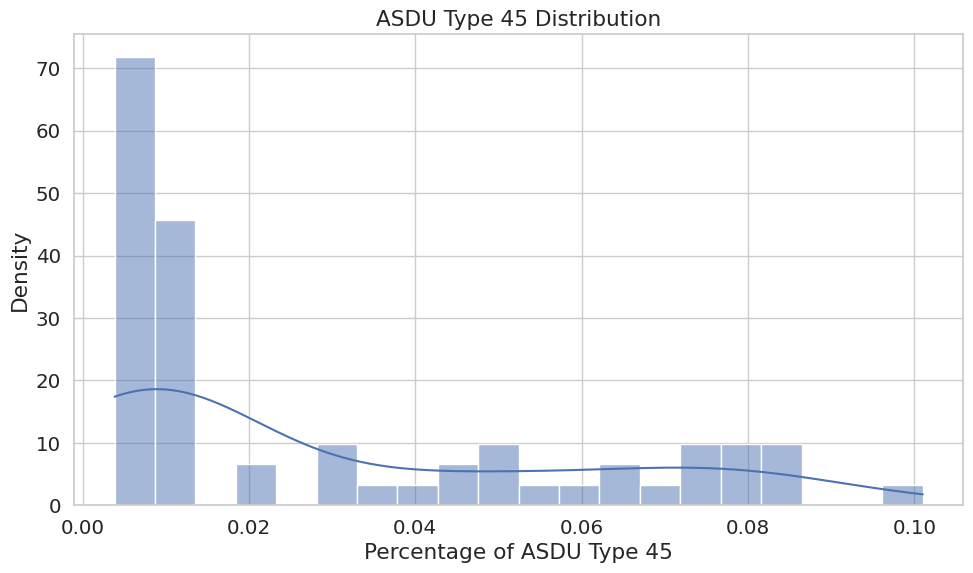

In [152]:
print(pcapFeatures["percASDU-45"])
# Plotting ASDU type distribution % (histogram as kernel density estimate)
plt.figure(figsize=(10, 6))
ax = sns.histplot(pcapFeatures["percASDU-45"], kde=True, stat="density", bins=20)
ax.set_title("ASDU Type 45 Distribution")
plt.xlabel("Percentage of ASDU Type 45")
plt.ylabel("Density")
plt.tight_layout()

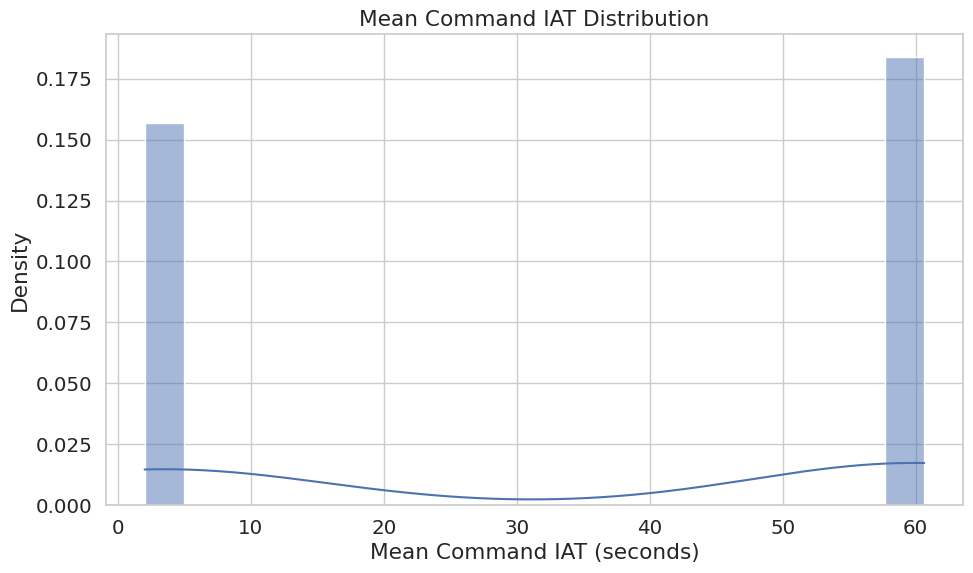

In [153]:
# meanCmdIAT distribution (histogram as kernel density estimate)
plt.figure(figsize=(10, 6))
ax = sns.histplot(pcapFeatures["meanCmdIAT"], kde=True, stat="density", bins=20)
ax.set_title("Mean Command IAT Distribution")
plt.xlabel("Mean Command IAT (seconds)")
plt.ylabel("Density")
plt.tight_layout()

In [166]:
# Add a feature "attack-strategy" based on ASDU type 45 percentage (if below 0.018, then "explicit", else "intermittent")
pcapFeatures["attack-strategy"] = pcapFeatures["percASDU-45"].apply(lambda x: "explicit" if x < 0.018 else "intermittent")
print("Num of explicit attacks:", len(pcapFeatures[pcapFeatures["attack-strategy"] == "explicit"]))
print("Num of intermittent attacks:", len(pcapFeatures[pcapFeatures["attack-strategy"] == "intermittent"]))

Num of explicit attacks: 36
Num of intermittent attacks: 27


Text(0, 0.5, 'Principal Component 2')

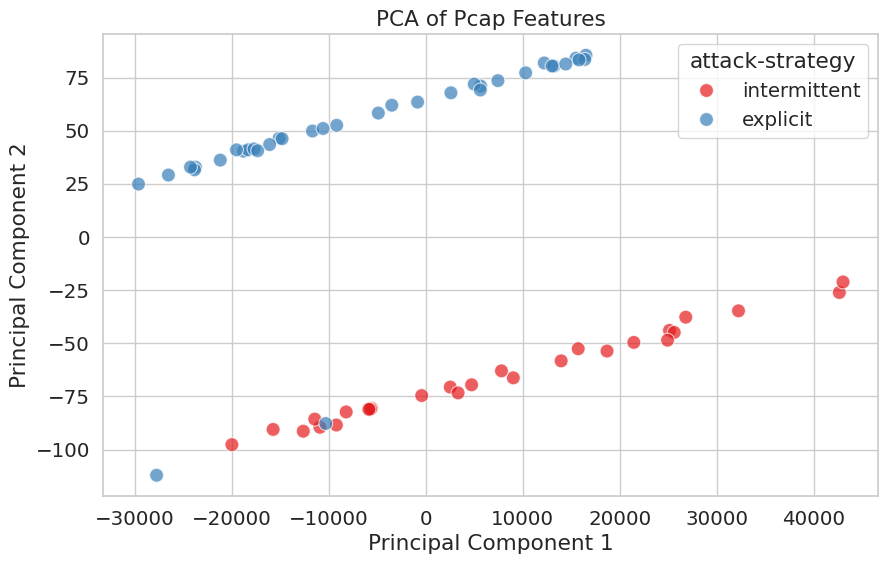

In [167]:
# Apply PCA on the features (2 principal components)
pca = PCA(n_components=2)
pcaResult = pca.fit_transform(pcapFeatures.drop(columns=["avgDegree", "maxEigVal", "attack-strategy"]))
pcaDf = pd.DataFrame(pcaResult, columns=["PC1", "PC2"])
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pcaDf, x="PC1", y="PC2", hue=pcapFeatures["attack-strategy"], palette="Set1", s=100, alpha=0.7)
plt.title("PCA of Pcap Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

/home/loki2/wattson/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Text(0, 0.5, 'T-SNE Component 2')

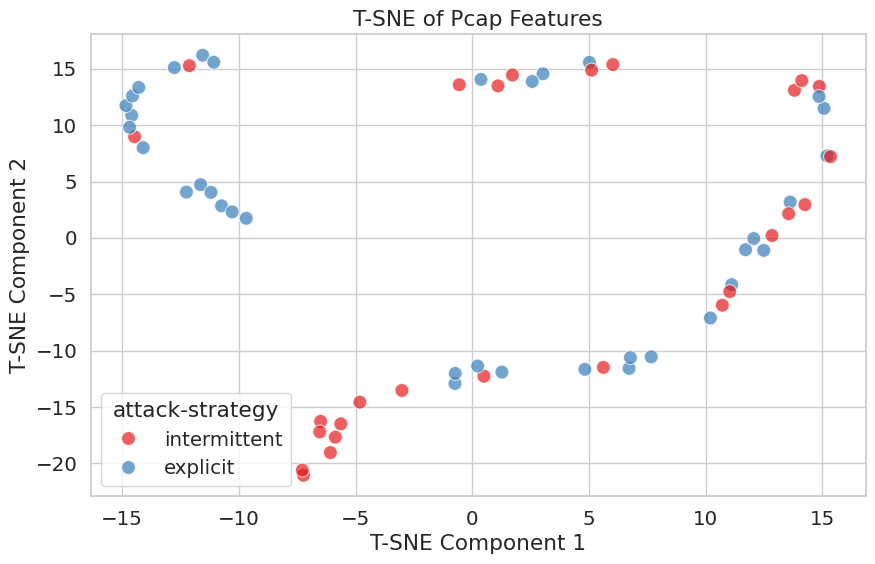

In [157]:
# Apply T-SNE on the features
tsne = TSNE(n_components=2, perplexity=5, n_iter=300)
tsneResult = tsne.fit_transform(pcapFeatures.drop(columns=["avgDegree", "maxEigVal", "attack-strategy"]))
tsneDf = pd.DataFrame(tsneResult, columns=["TSNE1", "TSNE2"])
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsneDf, x="TSNE1", y="TSNE2", hue=pcapFeatures["attack-strategy"], palette="Set1", s=100, alpha=0.7)
plt.title("T-SNE of Pcap Features")
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")